# Model Inference and Evaluation

Inference refers to the process of using a trained machine learning model to make predictions on new, unseen data. It is a key step in evaluating and deploying ML models.

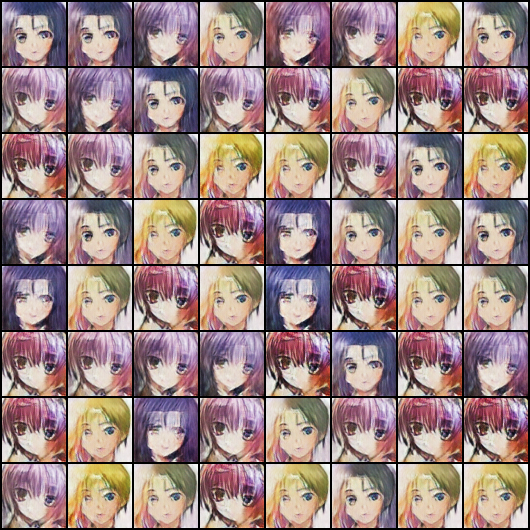

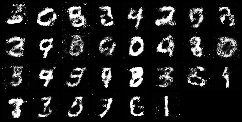

In [72]:
import torch.nn as nn
import torchvision.transforms as T
from torchvision.utils import make_grid
import torch
from IPython.display import display

@torch.inference_mode()
def inference_gan():
    generator = torch.jit.load("model_weights/mnist-G-torchscript.pt").to(device)
    x = torch.randn(30, 256, device='cuda')
    y = generator(x)
    y = y.view(-1, 1, 28, 28)  # reshape y to have 1 channel
    grid = make_grid(y.cpu().detach(), nrow=8)
    img = T.functional.to_pil_image(grid)
    return img

@torch.inference_mode()
def inference_dcgan():
    generator = torch.jit.load("model_weights/animefacedataset-G2-torchscript.pt").to(device)
    def denorm(img_tensors):
        stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
        return img_tensors * stats[1][0] + stats[0][0]
    x = torch.randn(64, 128, 1, 1, device='cuda')
    y = generator(x)
    y = y.view(-1, 3, 64, 64)  # reshape y to have 3 channels
    grid = make_grid(denorm(y.cpu().detach()), nrow=8)
    img = T.functional.to_pil_image(grid)
    return img

display(inference_dcgan(), inference_gan())

The code imports PyTorch and transforms modules. The @torch.inference_mode() decorator optimizes models for inference.

The inference_gan() method loads a MNIST generator model from a TorchScript file, passes randomized noise to it, processes the output as a PIL image and returns it. Similarly, inference_dcgan() loads an anime face generator model, passes noise, rescales the output using a denorm function, and returns the image. Finally, both generated images are displayed side-by-side using display().

During inference, noise vectors are fed to the generators instead of real samples. This tests the models' ability to transform unfamiliar randomized inputs into realistic outputs based on patterns learned during adversarial training.



## Evaluation
Upon inspection of the generated images, we observe key differences between the DCGAN and GAN models:

The DCGAN produces higher resolution 64x64 images compared to the 28x28 outputs of the GAN. This highlights the benefits of convolutional layers in handling larger images.

However, the anime faces from the DCGAN lack diversity - most seem to be minor variations of 5-8 faces. This likely indicates overfitting due to excessive training epochs.

In contrast, the GAN exhibits poor image quality but reasonable generalization. The MNIST digits display decent variety despite the low resolution.

In summary, the DCGAN generates higher fidelity anime faces at the cost of diversity, while the GAN generalizes better across more distinct digits but suffers in image quality.

Reducing DCGAN's training epochs could help improve its generalization by preventing overfitting. Overall, identifying these tradeoffs between resolution, diversity, and quality during inference helps evaluate the models' strengths and weaknesses after adversarial training. The results guide appropriate tuning towards optimal performance.